In [180]:
from __future__ import absolute_import, division, print_function, unicode_literals

#!pip install -q tensorflow==2.0.0-beta1
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from bs4 import BeautifulSoup
import requests
import cv2
import PIL.Image
import urllib
import time
print(tf.__version__)

2.0.0-beta1


In [127]:
IMAGE_SIZE = 400

In [195]:
def load_img_to_np_array(image_path, show_image = False):
    raw_image = load_img(image_path)
    resized_image = raw_image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image_arr = img_to_array(resized_image)
    imaimage_arrge = np.array(image_arr, dtype=float)

    if (show_image):
        plt.figure()
        plt.imshow(resized_image)
        
#     print(resized_image)
#     print(image_arr.shape)
    return resized_image, image_arr

def convert_rgb2lab(image_arr):
    X = rgb2lab(1.0/255*image_arr)[:,:,0]
    Y = rgb2lab(1.0/255*image_arr)[:,:,1:]
    Y /= 128
    X = X.reshape(IMAGE_SIZE, IMAGE_SIZE, 1)
    Y = Y.reshape(IMAGE_SIZE, IMAGE_SIZE, 2)
    
#     print(X.shape)
#     print(Y.shape)
    
#     print(Y.min())
#     print(Y.max())
    
    return X, Y

def show_images(original, model_prediction, grayscale):
    
    plt.figure(figsize=(20,20))

    plt.subplot(3,3,1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(original)
    plt.xlabel("original")

    plt.subplot(3,3,2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(grayscale, cmap =plt.cm.gray)
    plt.xlabel("grayscale")

    plt.subplot(3,3,3)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(model_prediction)
    plt.xlabel("rgb prediction")

    plt.show()
    
def predict(m_model, original_image, inputX):
    output = m_model.predict(inputX)
    output *= 128
    # Output colorizations
    cur = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3))
    cur[:,:,0] = inputX[0][:,:,0]
    cur[:,:,1:] = output[0]
    
    print(inputX.shape)
    print(output.shape)

    predicted_image = lab2rgb(cur)
    show_images(original_image, predicted_image, rgb2gray(predicted_image))
    
def load_and_preprocess_images(images_path, show_images=True):
    images_arr = []
    for i in range(len(images_path)):
        img, arr = load_img_to_np_array(images_path[i], show_image=show_images)
        images_arr.append((img, arr))
    return np.array(images_arr)

def convert_all_images_rgb2lab(images_arr):
    input_x = []
    output_y = []
    
    for image_arr in images_arr:
        in_x, out_y = convert_rgb2lab(image_arr[1])
        input_x.append(in_x)
        output_y.append(out_y)
    
    return np.array(input_x), np.array(output_y)

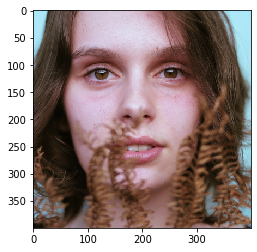

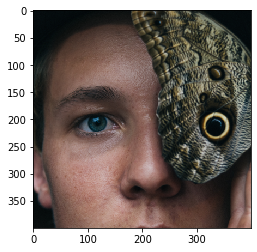

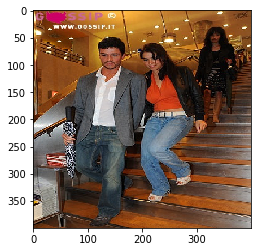

In [147]:
images_and_arrs = load_and_preprocess_images(["woman.jpg", 
                                             "man.jpg",
                                             "train/img_girlfriend_1.jpg"])

In [187]:
input_x, output_y = convert_all_images_rgb2lab(images_and_arrs)

print("input_x shape = " + str(input_x.shape))
print("output_y shape = " + str(output_y.shape))

for out_y in output_y:
    print(out_y.min())
    print(out_y.max())

input_x shape = (3, 400, 400, 1)
output_y shape = (3, 400, 400, 2)
-0.13980071179795356
0.3145791643609642
-0.22376064253198658
0.3747203220251739
-0.23727542593887835
0.6016653692066672


In [188]:
# Building the neural network
model = keras.Sequential()
model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2, input_shape=(None, None, 1)))
model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))

In [189]:
# Finish model
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, None, None, 8)     80        
_________________________________________________________________
conv2d_28 (Conv2D)           (None, None, None, 8)     584       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, None, None, 32)   

In [190]:
history = model.fit(x=input_x, 
          y=output_y,
          batch_size=1,
          epochs=400)

Train on 3 samples
Epoch 1/400
3/3 [==============================] - 1s 344ms/sample - loss: 0.2011 - accuracy: 0.4785
Epoch 2/400
3/3 [==============================] - 1s 220ms/sample - loss: 0.0185 - accuracy: 0.5146
Epoch 3/400
3/3 [==============================] - 1s 216ms/sample - loss: 0.0128 - accuracy: 0.4797
Epoch 4/400
3/3 [==============================] - 1s 214ms/sample - loss: 0.0113 - accuracy: 0.5468
Epoch 5/400
3/3 [==============================] - 1s 212ms/sample - loss: 0.0113 - accuracy: 0.5481
Epoch 6/400
3/3 [==============================] - 1s 218ms/sample - loss: 0.0110 - accuracy: 0.5631
Epoch 7/400
3/3 [==============================] - 1s 217ms/sample - loss: 0.0110 - accuracy: 0.5559
Epoch 8/400
3/3 [==============================] - 1s 216ms/sample - loss: 0.0107 - accuracy: 0.5963
Epoch 9/400
3/3 [==============================] - 1s 231ms/sample - loss: 0.0103 - accuracy: 0.6007
Epoch 10/400
3/3 [==============================] - 1s 208ms/sample - lo

3/3 [==============================] - 1s 202ms/sample - loss: 0.0048 - accuracy: 0.6954
Epoch 82/400
3/3 [==============================] - 1s 214ms/sample - loss: 0.0073 - accuracy: 0.7170
Epoch 83/400
3/3 [==============================] - 1s 215ms/sample - loss: 0.0052 - accuracy: 0.7102
Epoch 84/400
3/3 [==============================] - 1s 206ms/sample - loss: 0.0051 - accuracy: 0.7066
Epoch 85/400
3/3 [==============================] - 1s 208ms/sample - loss: 0.0063 - accuracy: 0.6122
Epoch 86/400
3/3 [==============================] - 1s 215ms/sample - loss: 0.0061 - accuracy: 0.6869
Epoch 87/400
3/3 [==============================] - 1s 212ms/sample - loss: 0.0048 - accuracy: 0.7324
Epoch 88/400
3/3 [==============================] - 1s 211ms/sample - loss: 0.0045 - accuracy: 0.7021
Epoch 89/400
3/3 [==============================] - 1s 213ms/sample - loss: 0.0051 - accuracy: 0.7125
Epoch 90/400
3/3 [==============================] - 1s 218ms/sample - loss: 0.0047 - accuracy: 

3/3 [==============================] - 1s 219ms/sample - loss: 0.0031 - accuracy: 0.7376
Epoch 161/400
3/3 [==============================] - 1s 215ms/sample - loss: 0.0030 - accuracy: 0.7391
Epoch 162/400
3/3 [==============================] - 1s 213ms/sample - loss: 0.0029 - accuracy: 0.7517
Epoch 163/400
3/3 [==============================] - 1s 224ms/sample - loss: 0.0027 - accuracy: 0.7436
Epoch 164/400
3/3 [==============================] - 1s 213ms/sample - loss: 0.0033 - accuracy: 0.7362
Epoch 165/400
3/3 [==============================] - 1s 213ms/sample - loss: 0.0043 - accuracy: 0.6758
Epoch 166/400
3/3 [==============================] - 1s 210ms/sample - loss: 0.0033 - accuracy: 0.7346
Epoch 167/400
3/3 [==============================] - 1s 228ms/sample - loss: 0.0028 - accuracy: 0.7506
Epoch 168/400
3/3 [==============================] - 1s 217ms/sample - loss: 0.0025 - accuracy: 0.7142
Epoch 169/400
3/3 [==============================] - 1s 205ms/sample - loss: 0.0048 - a

3/3 [==============================] - 1s 259ms/sample - loss: 0.0021 - accuracy: 0.7482
Epoch 240/400
3/3 [==============================] - 1s 242ms/sample - loss: 0.0020 - accuracy: 0.7738
Epoch 241/400
3/3 [==============================] - 1s 237ms/sample - loss: 0.0018 - accuracy: 0.7500
Epoch 242/400
3/3 [==============================] - 1s 248ms/sample - loss: 0.0022 - accuracy: 0.7248
Epoch 243/400
3/3 [==============================] - 1s 227ms/sample - loss: 0.0023 - accuracy: 0.7532
Epoch 244/400
3/3 [==============================] - 1s 235ms/sample - loss: 0.0026 - accuracy: 0.7485
Epoch 245/400
3/3 [==============================] - 1s 221ms/sample - loss: 0.0023 - accuracy: 0.7792
Epoch 246/400
3/3 [==============================] - 1s 213ms/sample - loss: 0.0033 - accuracy: 0.7294
Epoch 247/400
3/3 [==============================] - 1s 232ms/sample - loss: 0.0043 - accuracy: 0.7370
Epoch 248/400
3/3 [==============================] - 1s 279ms/sample - loss: 0.0022 - a

3/3 [==============================] - 1s 253ms/sample - loss: 0.0016 - accuracy: 0.7647
Epoch 319/400
3/3 [==============================] - 1s 245ms/sample - loss: 0.0019 - accuracy: 0.7704
Epoch 320/400
3/3 [==============================] - 1s 298ms/sample - loss: 0.0022 - accuracy: 0.7549
Epoch 321/400
3/3 [==============================] - 1s 278ms/sample - loss: 0.0021 - accuracy: 0.7706
Epoch 322/400
3/3 [==============================] - 1s 286ms/sample - loss: 0.0017 - accuracy: 0.7847
Epoch 323/400
3/3 [==============================] - 1s 290ms/sample - loss: 0.0021 - accuracy: 0.7722
Epoch 324/400
3/3 [==============================] - 1s 304ms/sample - loss: 0.0016 - accuracy: 0.7714
Epoch 325/400
3/3 [==============================] - 1s 322ms/sample - loss: 0.0018 - accuracy: 0.7658
Epoch 326/400
3/3 [==============================] - 1s 263ms/sample - loss: 0.0018 - accuracy: 0.7552
Epoch 327/400
3/3 [==============================] - 1s 236ms/sample - loss: 0.0031 - a

3/3 [==============================] - 1s 247ms/sample - loss: 0.0016 - accuracy: 0.7955
Epoch 398/400
3/3 [==============================] - 1s 229ms/sample - loss: 0.0020 - accuracy: 0.7724
Epoch 399/400
3/3 [==============================] - 1s 246ms/sample - loss: 0.0022 - accuracy: 0.7929
Epoch 400/400
3/3 [==============================] - 1s 241ms/sample - loss: 0.0019 - accuracy: 0.7828


In [191]:
ts = int(time.time())
model.save('models/Colorize-V1.h5')

In [197]:
# Recreate the exact same model, including weights and optimizer.
new_model = keras.models.load_model('models/Colorize-V1.h5')
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, None, None, 8)     80        
_________________________________________________________________
conv2d_28 (Conv2D)           (None, None, None, 8)     584       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, None, None, 32)   

(1, 400, 400, 1)
(1, 400, 400, 2)


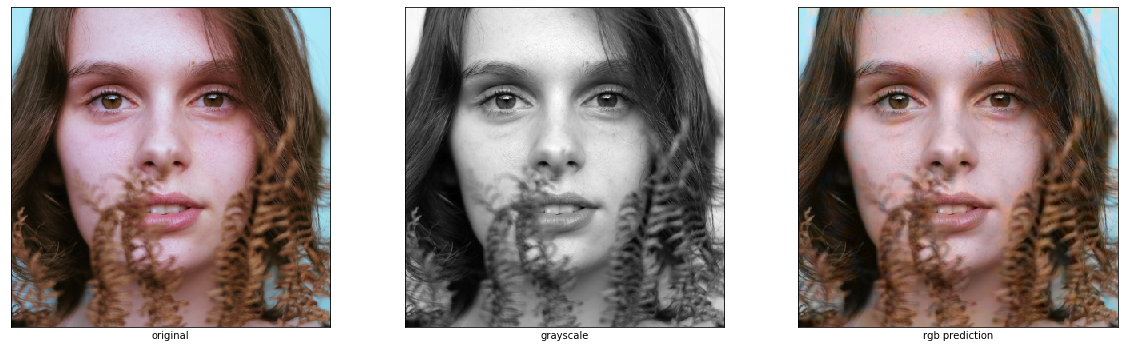

(1, 400, 400, 1)
(1, 400, 400, 2)


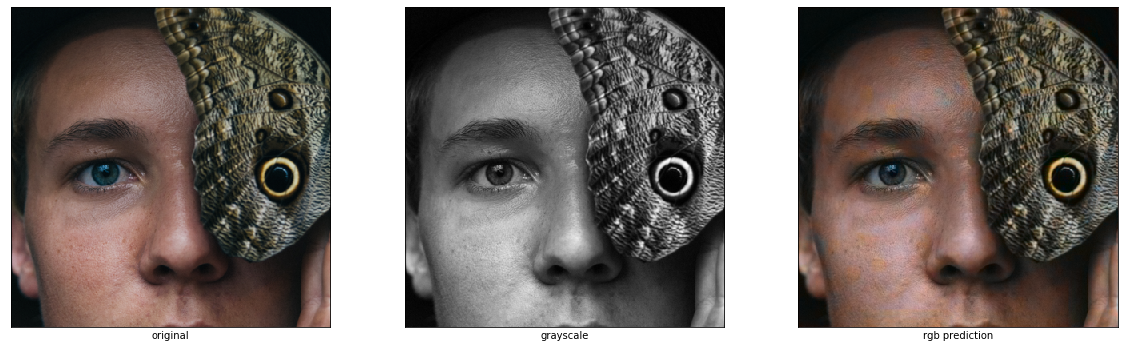

(1, 400, 400, 1)
(1, 400, 400, 2)


/anaconda3/lib/python3.6/site-packages/skimage/color/colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 66 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


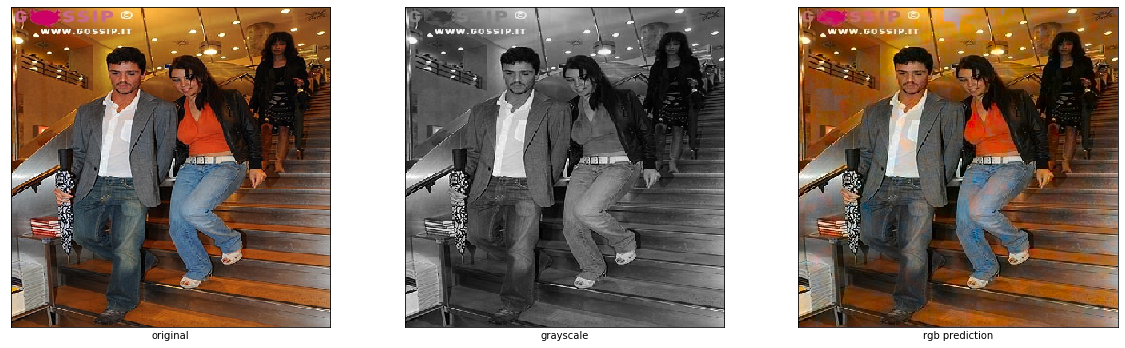

(1, 400, 400, 1)
(1, 400, 400, 2)


/anaconda3/lib/python3.6/site-packages/skimage/color/colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 24 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


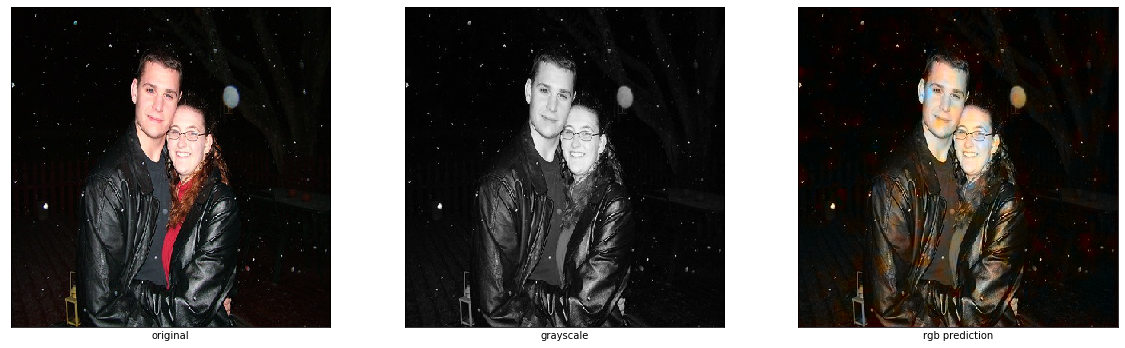

In [199]:
test_image, test_arr = load_img_to_np_array("woman.jpg", show_image=False)
test_x, test_y = convert_rgb2lab(test_arr)
predict(model, test_image, test_x.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))

test_image, test_arr = load_img_to_np_array("man.jpg", show_image=False)
test_x, test_y = convert_rgb2lab(test_arr)
predict(model, test_image, test_x.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))

test_image, test_arr = load_img_to_np_array("train/img_girlfriend_1.jpg", show_image=False)
test_x, test_y = convert_rgb2lab(test_arr)
predict(model, test_image, test_x.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))

test_image, test_arr = load_img_to_np_array("train/img_girlfriend_2.jpg", show_image=False)
test_x, test_y = convert_rgb2lab(test_arr)
predict(model, test_image, test_x.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))